# Predicting MLB Hall of Famers

#### Prepared for Udacity's Data Analyst Nanodegree - P2: Investigate a Dataset

## Introduction
Just because the election for 2017 crop of Hall of Famers only finished 5 months ago doesn't mean it's too early to start wondering which current major leaguers will be enshrined in Cooperstown someday. In fact it's only 5 months until the 2018 ballot is released so I think now is quite a felicitous time to examine previous ballots. Two questions I want to answer at the end of this project are:

1. Who got elected into the HoF and how similar/different were they from those who didn't?
2. Can we predict whose who will make it to the HoF?

Although there are four main position players can assume in a game of baseball: Infielders, Outfielders, Pitchers, and Catchers, the focus of this project will be on Infielders and Outfielders.

## Background information
The National Baseball Hall of Fame and Museum is located in Cooperstown, New York and was dedicated in 1939. A baseball player can be elected to the Hall of Fame if they meet the following criteria:

1. The player must have competed in at least ten seasons;
2. The player has been retired for at least five seasons;
3. A screening committee must approve the player’s worthiness to be included on the ballot and most players who played regularly for ten or more years are deemed worthy;
4. The player must not be on the ineligible list (that means that the player should not be banned from baseball);
5. A player is considered elected if he receives at least 75% of the vote in the election; and
6. A player stays on the ballot the following year if they receive at least 5% of the vote and can appear on ballots for a maximum of 10 years.

These criteria tell us what information we need to gather before answering our questions, namely how long each player competed, when they retired, whether they have been banned from the game, etc. In the next part, we are going to find out where to obtain these information.

## Dataset
The 2017 version of [Lahman's Baseball Database](http://www.seanlahman.com/baseball-archive/statistics/) contains complete batting and pitching statistics from 1871 to 2017, plus fielding statistics, standings, team stats, managerial records, post-season data, and more. The full database, as comma-separated files, can be downloaded from [here](http://seanlahman.com/files/database/baseballdatabank-2017.1.zip). However, for our predictions, we only need the following .csv files:
* Master.csv;
* Batting.csv;
* Fielding.csv;
* Teams.csv;
* AwardsPlayers.csv;
* AllstarFull.csv;
* Appearances.csv; and last but not least
* HallOfFame.csv.

Unfortunately, it's not possible to tell if a player has been banned from baseball from this database, but we can always look it up on the net. Next we will read in the data and clean them.

## Data Cleaning and Pre-processing

In [1486]:
# Import data to DataFrames
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Read in the CSV files
master_df = pd.read_csv('Master.csv',usecols=['playerID','nameFirst','nameLast','bats','throws','finalGame'])
fielding_df = pd.read_csv('Fielding.csv',usecols=['playerID','A','E','DP'])
batting_df = pd.read_csv('Batting.csv', usecols = ['playerID', 'AB', 'R', 'H', '2B', '3B', 'HR', 'RBI',\
                                                    'SB', 'CS', 'BB','SO', 'IBB', 'HBP', 'SH', 'SF'])
teams_df = pd.read_csv('Teams.csv')
awards_df = pd.read_csv('AwardsPlayers.csv', usecols=['playerID','awardID','yearID'])
allstar_df = pd.read_csv('AllstarFull.csv', usecols=['playerID','yearID'])
hof_df = pd.read_csv('HallOfFame.csv',usecols=['playerID','yearid','votedBy','needed_note','inducted','category'])
appearances_df = pd.read_csv('Appearances.csv')

In general, we are only interested in players elected by the BBWAA, but we should also include two players (Roberto Clemente and Lou Gehrig) who were elected via “Special Election”, because they clearly had Hall of Fame stats, but simply bypassed the process due to untimely circumstances.

Moreover, there were three occasions - in 1949, 1964, and 1967 - when the BBWAA conducted a special run-off election whereby the one player who received the most run-off votes would be elected to the HoF, so we should include players who got elected with a run-off ballot as well.

In [1487]:
hof = hof_df[((hof_df['votedBy'] == 'BBWAA') | (hof_df['votedBy'] == 'Special Election')) | (hof_df['votedBy'] == 'Run Off')]
hof = hof[(hof['category'] == 'Player') & (hof['inducted'] == 'Y')]

# Drop these columns as no longer useful
hof = hof.drop(['category', 'inducted', 'needed_note', 'yearid'], axis = 1)

# Convert `votedBy` column to numeric
hof['votedBy'] = 1

# Give `votedBy` column a better name
hof.rename(columns = {'votedBy':'HoF'}, inplace = True)

Next we'll gather information about each player's performance, starting with batting statistics:

In [1488]:
# Group by playerID
batting = batting_df.groupby('playerID', as_index = False).sum()
batting = batting.fillna(0)
batting.head()

,playerID,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF
0,aardsda01,4,0,0,0,0,0,0.0,0.0,0.0,0,2.0,0.0,0.0,1.0,0.0
1,aaronha01,12364,2174,3771,624,98,755,2297.0,240.0,73.0,1402,1383.0,293.0,32.0,21.0,121.0
2,aaronto01,944,102,216,42,6,13,94.0,9.0,8.0,86,145.0,3.0,0.0,9.0,6.0
3,aasedo01,5,0,0,0,0,0,0.0,0.0,0.0,0,3.0,0.0,0.0,0.0,0.0
4,abadan01,21,1,2,0,0,0,0.0,0.0,1.0,4,5.0,0.0,0.0,0.0,0.0


The columns have somewhat cryptic names, but you can always take a look at the information at the [README page](http://seanlahman.com/files/database/readme2016.txt) to see what they mean. 

Next up is fielding statistics:

In [1489]:
# Group by playerID
fielding = fielding_df.groupby('playerID', as_index = False).sum()
fielding = fielding.fillna(0)
fielding.head()

,playerID,A,E,DP
0,aardsda01,29.0,3.0,2.0
1,aaronha01,429.0,144.0,218.0
2,aaronto01,113.0,22.0,124.0
3,aasedo01,135.0,13.0,10.0
4,abadan01,1.0,1.0,3.0


Next, we will look at the `allstar_df` DataFrame. It contains information on which players made appearances in Allstar games. The Allstar game is an exhibition game played each year at mid-season. Major League Baseball consists of two leagues: the American league and the National league. The top 25 players from each league are selected to represent their league in the Allstar game. Hence to make appearances in the Allstar game is quite an achievement and we want to know how many Allstar games each player has participated in. 

In [1490]:
allstar = allstar_df.groupby('playerID').count().reset_index()

It might be a good idea to rename the column 'yearID' to something else to avoid confusion.

In [1491]:
allstar.rename(columns = {'yearID':'years_allstar'}, inplace = True)

Next up is `awards_df`, let's see how many different awards there are

In [1492]:
awards_df['awardID'].unique()

array(['Pitching Triple Crown', 'Triple Crown',
       'Baseball Magazine All-Star', 'Most Valuable Player',
       'TSN All-Star', 'TSN Guide MVP',
       'TSN Major League Player of the Year', 'TSN Pitcher of the Year',
       'TSN Player of the Year', 'Rookie of the Year', 'Babe Ruth Award',
       'Lou Gehrig Memorial Award', 'World Series MVP', 'Cy Young Award',
       'Gold Glove', 'TSN Fireman of the Year', 'All-Star Game MVP',
       'Hutch Award', 'Roberto Clemente Award', 'Rolaids Relief Man Award',
       'NLCS MVP', 'ALCS MVP', 'Silver Slugger', 'Branch Rickey Award',
       'Hank Aaron Award', 'TSN Reliever of the Year',
       'Comeback Player of the Year', 'Outstanding DH Award',
       'Reliever of the Year Award'], dtype=object)

That's a *lot* of awards, but not all of them are correlated with being voted into HoF. In fact, let's just focus on the more important ones, namely: Most Valuable Player, Rookie of the Year, Gold Glove, Silver Slugger, and World Series MVP awards. (Cy Young, though being a major award, is only for pitchers and thus excluded.) Now we need to count how many different awards each player managed to win.

In [1493]:
# Keeping only important awards
awards_list = ['Most Valuable Player','Rookie of the Year','Gold Glove','Silver Slugger','World Series MVP']
awards = awards_df[awards_df['awardID'].isin(awards_list)]

# Pivot the data frame to count the number of different awards
awards = awards.pivot_table(index = 'playerID', columns = 'awardID', aggfunc='count')

# Flatten the pivot table
awards = pd.DataFrame(awards.to_records())

Notice that we have inadvertently introduced a decent number of NA values that are actually zeros when making the pivot table, so we'll have to replace them accordingly. We have also changed the column names as a result of flattening our pivot table. The simplest way to fix this is by string match-and-replace. 

In [1494]:
# Fix column names after flattening
awards.columns = [col.replace("('yearID', '", "").replace("')", "") \
                     for col in awards.columns]

awards = awards.fillna(0)

At this point we have gathered quite a decent amount of information on players' statistics, it's a good idea to try and compile them together:

In [1495]:
player_stats = batting.merge(fielding, on = 'playerID', how ='left')
player_stats = player_stats.merge(allstar, on = 'playerID', how ='left')
player_stats = player_stats.merge(awards, on = 'playerID', how ='left')
player_stats = player_stats.merge(hof, on = 'playerID', how ='left')
player_stats = player_stats.fillna(0)
player_stats.head()

,playerID,AB,R,H,2B,3B,HR,RBI,SB,CS,...,A,E,DP,years_allstar,Gold Glove,Most Valuable Player,Rookie of the Year,Silver Slugger,World Series MVP,HoF
0,aardsda01,4,0,0,0,0,0,0.0,0.0,0.0,...,29.0,3.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,aaronha01,12364,2174,3771,624,98,755,2297.0,240.0,73.0,...,429.0,144.0,218.0,25.0,3.0,1.0,0.0,0.0,0.0,1.0
2,aaronto01,944,102,216,42,6,13,94.0,9.0,8.0,...,113.0,22.0,124.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,aasedo01,5,0,0,0,0,0,0.0,0.0,0.0,...,135.0,13.0,10.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,abadan01,21,1,2,0,0,0,0.0,0.0,1.0,...,1.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We also need to know when a player played their last game, these can be found in the `master_df` DataFrame:

In [1496]:
master_df.head()

,playerID,nameFirst,nameLast,bats,throws,finalGame
0,aardsda01,David,Aardsma,R,R,2015-08-23
1,aaronha01,Hank,Aaron,R,R,1976-10-03
2,aaronto01,Tommie,Aaron,R,R,1971-09-26
3,aasedo01,Don,Aase,R,R,1990-10-03
4,abadan01,Andy,Abad,L,L,2006-04-13


Data in `bats` and `throws` columns are binary values with `R` (`L`) indicating a player's batting/throwing hand is his right (left), so it's much simpler to represent the information with 0-1 integers.

In [1497]:
# Create a function to convert the `bats` and `throws` colums to numeric
def bats_throws(col):
    if col == "R":
        return 1
    else:
        return 0
    
#player_stats['bats_R'] = player_stats['bats'].apply(bats_throws)
#player_stats['throws_R'] = player_stats['throws'].apply(bats_throws)

master_df['bats_R'] = master_df['bats'].apply(bats_throws)
master_df['throws_R'] = master_df['throws'].apply(bats_throws)

# Drop the old columns
master_df = master_df.drop(['bats','throws'], axis = 1)

Moreover, the `debut` and `finalGame` columns are currently strings so we'll need to convert them to datetime object and extract the year, since we don't need details as granular as date and month.

In [1498]:
from datetime import datetime

def getYear(datestring):
    return datetime.strptime(datestring, '%Y-%m-%d').year

# Drop rows that have NA values
master = master_df.dropna(subset = ['finalGame'])

# Get years from strings
master = master.join(master['finalGame'].map(getYear), lsuffix='_')
master = master.drop('finalGame_', axis = 1)

In [1499]:
master.head()

,playerID,nameFirst,nameLast,bats_R,throws_R,finalGame
0,aardsda01,David,Aardsma,1,1,2015
1,aaronha01,Hank,Aaron,1,1,1976
2,aaronto01,Tommie,Aaron,1,1,1971
3,aasedo01,Don,Aase,1,1,1990
4,abadan01,Andy,Abad,0,0,2006


Next up is the `appearances_df` DataFrame. This contains information on how many appearances each player had at each position for each year and will tell us how long a player has competed in the game. Let's take a look at the first few rows of the DataFrame to see what we have.

In [1500]:
appearances_df.head()

,yearID,teamID,lgID,playerID,G_all,GS,G_batting,G_defense,G_p,G_c,...,G_2b,G_3b,G_ss,G_lf,G_cf,G_rf,G_of,G_dh,G_ph,G_pr
0,1871,TRO,NaN,abercda01,1,NaN,1,1,0,0,...,0,0,1,0,0,0,0,NaN,NaN,NaN
1,1871,RC1,NaN,addybo01,25,NaN,25,25,0,0,...,22,0,3,0,0,0,0,NaN,NaN,NaN
2,1871,CL1,NaN,allisar01,29,NaN,29,29,0,0,...,2,0,0,0,29,0,29,NaN,NaN,NaN
3,1871,WS3,NaN,allisdo01,27,NaN,27,27,0,27,...,0,0,0,0,0,0,0,NaN,NaN,NaN
4,1871,RC1,NaN,ansonca01,25,NaN,25,25,0,5,...,2,20,0,1,0,0,1,NaN,NaN,NaN


In [1501]:
# Drop unnecessary columns
appearances_df = appearances_df.drop(['G_ph', 'G_pr'], axis = 1)
appearances = appearances_df.groupby(['playerID'], as_index = False).sum()
appearances = appearances.fillna(0)

In [1502]:
appearances_df.columns

Index(['yearID', 'teamID', 'lgID', 'playerID', 'G_all', 'GS', 'G_batting',
       'G_defense', 'G_p', 'G_c', 'G_1b', 'G_2b', 'G_3b', 'G_ss', 'G_lf',
       'G_cf', 'G_rf', 'G_of', 'G_dh'],
      dtype='object')

As mentioned earlier, this project is focused on infielders and outfielders only, so we need to pick players who only play at these positions. However, some players played at multiple different positions in the earlier years of MLB, so how are we going to filter out pitchers and catchers? There are no hard and fast rules, but we can convert these numbers into percentages and exclude people who played more than, say, 10% of their games at either of these positions.

In [1503]:
positions = appearances_df.columns[5:]

# Loop through the list and divide each column by the players total games played
for col in positions:
    column = col + '_percent'
    appearances[column] = appearances[col] / appearances['G_all'] 

In [1504]:
# Eliminate players who played 10% or more of their games as Pitchers or Catchers
appearances = appearances[(appearances['G_p_percent'] < 0.1) & (appearances['G_c_percent'] < 0.1)]

# Drop columns that are no longer useful
appearances = appearances.drop(['G_p_percent','G_c_percent', 'yearID'], axis = 1)
appearances = appearances.drop(positions.tolist(), axis = 1)

In [1505]:
appearances.head()

,playerID,G_all,GS_percent,G_batting_percent,G_defense_percent,G_1b_percent,G_2b_percent,G_3b_percent,G_ss_percent,G_lf_percent,G_cf_percent,G_rf_percent,G_of_percent,G_dh_percent
1,aaronha01,3298,0.962098,1.0,0.905094,0.063675,0.013038,0.002122,0.000000,0.095512,0.093390,0.659187,0.836871,0.060946
2,aaronto01,437,0.471396,1.0,0.791762,0.530892,0.016018,0.022883,0.000000,0.308924,0.002288,0.004577,0.313501,0.000000
4,abadan01,15,0.266667,1.0,0.600000,0.533333,0.000000,0.000000,0.000000,0.000000,0.000000,0.066667,0.066667,0.000000
6,abadijo01,12,0.000000,1.0,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,abbated01,855,0.000000,1.0,1.000000,0.000000,0.490058,0.023392,0.453801,0.000000,0.002339,0.001170,0.003509,0.000000


The data look fine but... how are we going to deal with the years? It is unlikely that the number 1950 will have the same relationship to the rest of the data that the model will infer, so is it OK to drop them like we just did? 

No it's not. It turns out as MLB progressed, different eras emerged where the amount of runs per game increased or decreased significantly. This means that when a player played has a large influence on that player’s career statistics. The HoF voters take this into account when voting players in, so our model needs that information too. To get information such as runs allowed and games played over the years, we need to turn to the `teams_df` DataFrame.

We only need to consider columns needed to calculate runs per game per year, the rest we can safely ignore. Also looking back at the history of MLB, the rules of baseball had not settled into place before 1900 and the game was a totally different beast back then so it makes sense to remove these rows from the data.

In [1506]:
# Runs and games per year
runs_games = teams_df.groupby('yearID').sum()[['G','R']]
runs_games['RPG'] = runs_games['R'] / runs_games['G']
runs_games = runs_games.loc[1901:]
runs_games.head()

,G,R,RPG
yearID,,,
1901,2220,11068,4.985586
1902,2230,9883,4.431839
1903,2228,9892,4.439856
1904,2498,9307,3.725781
1905,2474,9640,3.896524


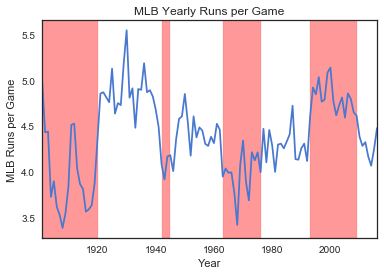

In [1507]:
# Plot number of runs per game over time
runs_games['RPG'].plot()
plt.title('MLB Yearly Runs per Game')
plt.xlabel('Year')
plt.ylabel('MLB Runs per Game')
plt.axvspan(1901, 1920, color='red', alpha=0.4)
plt.axvspan(1942, 1945, color='red', alpha=0.4)
plt.axvspan(1963, 1976, color='red', alpha=0.4)
plt.axvspan(1993, 2009, color='red', alpha=0.4)

There were indeed some periods when the number of runs per game was much higher than others. For example, the years from 1920 - 1941 saw an unprecedented high number of runs scored per game and was often referred to as the Lively Ball Era. Another sharp rise in runs per game occurred during early '90s to 2008, the Steroid Era. To capture this information, we need to convert years to eras in our player_stats DataFrame and turn them into new features (columns). We can re-use part of the codes we wrote for awards_df to accomplish this.

In [1508]:
yr_appearances = appearances_df.copy()[['yearID','playerID','teamID']]

# Remove players in or before 1900
yr_appearances = yr_appearances[yr_appearances['yearID'] > 1900]

def toEra(year):
    if int(year) < 1921:
        return '1901-1920'
    elif int(year) < 1942:
        return '1921-1941'
    elif int(year) < 1946:
        return '1942-1945'
    elif int(year) < 1963:
        return '1946-1962'
    elif int(year) < 1977:
        return '1963-1976'
    elif int(year) < 1993:
        return '1977-1992'
    elif int(year) < 2010:
        return '1993-2009'
    else:
        return 'post2009'

yr_appearances['yearID'] = yr_appearances['yearID'].map(toEra)

# Pivot the data frame to count the number of different awards
yr_appearances = yr_appearances.pivot_table(index='playerID', columns = 'yearID', aggfunc='count')

# Flatten the pivot table
yr_appearances = pd.DataFrame(yr_appearances.to_records())

# Fix column names after flattening
yr_appearances.columns = [col.replace("('teamID', '", "").replace("')", "") \
                     for col in yr_appearances.columns]

yr_appearances = yr_appearances.fillna(0)

# Number of years playing
yr_appearances['years_playing'] = yr_appearances.sum(axis = 1)

yr_appearances = yr_appearances.merge(appearances, on = 'playerID', how = 'inner')
yr_appearances.head()

,playerID,1901-1920,1921-1941,1942-1945,1946-1962,1963-1976,1977-1992,1993-2009,post2009,years_playing,...,G_defense_percent,G_1b_percent,G_2b_percent,G_3b_percent,G_ss_percent,G_lf_percent,G_cf_percent,G_rf_percent,G_of_percent,G_dh_percent
0,aaronha01,0.0,0.0,0.0,9.0,14.0,0.0,0.0,0.0,23.0,...,0.905094,0.063675,0.013038,0.002122,0.000000,0.095512,0.093390,0.659187,0.836871,0.060946
1,aaronto01,0.0,0.0,0.0,1.0,6.0,0.0,0.0,0.0,7.0,...,0.791762,0.530892,0.016018,0.022883,0.000000,0.308924,0.002288,0.004577,0.313501,0.000000
2,abadan01,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,3.0,...,0.600000,0.533333,0.000000,0.000000,0.000000,0.000000,0.000000,0.066667,0.066667,0.000000
3,abbated01,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,...,1.000000,0.000000,0.490058,0.023392,0.453801,0.000000,0.002339,0.001170,0.003509,0.000000
4,abbotje01,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,5.0,...,0.793991,0.000000,0.000000,0.000000,0.000000,0.270386,0.347639,0.236052,0.793991,0.051502


Now that we have gathered pretty much all necessary information, it's time for a final merge. It's likely that new NA values will be created as a result of merging, so we need to check if there are any of them as well.

In [1509]:
df = master.merge(player_stats, on = 'playerID', how ='left')
df = df.merge(yr_appearances, on = 'playerID', how ='inner')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7237 entries, 0 to 7236
Data columns (total 53 columns):
playerID                7237 non-null object
nameFirst               7235 non-null object
nameLast                7237 non-null object
bats_R                  7237 non-null int64
throws_R                7237 non-null int64
finalGame               7237 non-null int64
AB                      7237 non-null float64
R                       7237 non-null float64
H                       7237 non-null float64
2B                      7237 non-null float64
3B                      7237 non-null float64
HR                      7237 non-null float64
RBI                     7237 non-null float64
SB                      7237 non-null float64
CS                      7237 non-null float64
BB                      7237 non-null float64
SO                      7237 non-null float64
IBB                     7237 non-null float64
HBP                     7237 non-null float64
SH                      7237

The only column that has NA values is `nameFirst`, and since there are only two of them, let's not worry about these. We have finally consolidated everything into a single DataFrame with everything we need to know about the players. In the next step, we are going to draw some insights from the data by adding new features.

In [1510]:
df.head()

,playerID,nameFirst,nameLast,bats_R,throws_R,finalGame,AB,R,H,2B,...,G_defense_percent,G_1b_percent,G_2b_percent,G_3b_percent,G_ss_percent,G_lf_percent,G_cf_percent,G_rf_percent,G_of_percent,G_dh_percent
0,aaronha01,Hank,Aaron,1,1,1976,12364.0,2174.0,3771.0,624.0,...,0.905094,0.063675,0.013038,0.002122,0.000000,0.095512,0.093390,0.659187,0.836871,0.060946
1,aaronto01,Tommie,Aaron,1,1,1971,944.0,102.0,216.0,42.0,...,0.791762,0.530892,0.016018,0.022883,0.000000,0.308924,0.002288,0.004577,0.313501,0.000000
2,abadan01,Andy,Abad,0,0,2006,21.0,1.0,2.0,0.0,...,0.600000,0.533333,0.000000,0.000000,0.000000,0.000000,0.000000,0.066667,0.066667,0.000000
3,abbated01,Ed,Abbaticchio,1,1,1910,3044.0,355.0,772.0,99.0,...,1.000000,0.000000,0.490058,0.023392,0.453801,0.000000,0.002339,0.001170,0.003509,0.000000
4,abbotje01,Jeff,Abbott,1,0,2001,596.0,82.0,157.0,33.0,...,0.793991,0.000000,0.000000,0.000000,0.000000,0.270386,0.347639,0.236052,0.793991,0.051502


## Feature Engineering

We'll start by adding important baseball statistics such as batting average, on-base percentage, slugging percentage, and on-base plus slugging percentage, using the following formulas:

* Batting Ave. = Hits / At Bats
* Plate Appearances = At Bats + Walks + Sacrifice Flys & Hits + Hit by Pitch
* On-base = (Hits + Walks + Hit by Pitch) / Plate Appearances
* Slugging = ((Home Runs x 4) + (Triples x 3) + (Doubles x 2) + Singles) / At Bats
* On-Base plus Slugging = On-base + Slugging

Since we are computing a lot of ratios, NA values may come about which we'll have to remove 

In [1511]:
# Create Batting Average (`AVE`) column
df['AVE'] = df['H'] / df['AB']

# Create On Base Percent (`OBP`) column
plate_appearances = (df['AB'] + df['BB'] + df['SF'] + df['SH'] + df['HBP'])
df['OBP'] = (df['H'] + df['BB'] + df['HBP']) / plate_appearances

# Create Slugging Percent (`Slug_Percent`) column
single = ((df['H'] - df['2B']) - df['3B']) - df['HR']
df['Slug_Percent'] = ((df['HR'] * 4) + (df['3B'] * 3) + (df['2B'] * 2) + single) / df['AB']

# Create On Base plus Slugging Percent (`OPS`) column
hr = df['HR'] * 4
triple = df['3B'] * 3
double = df['2B'] * 2
df['OPS'] = df['OBP'] + df['Slug_Percent']

In [1512]:
df = df.dropna()
print(df.isnull().sum(axis=0).tolist())

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Yass! Now we are free of the NA plague. Before we move on to create some plots, let's try to identify the outliers in our data. They are players who boasted HoF-worthy stats but were ignored by HoF voters due to match-fixing scandals and performance enhancing drugs (PED) allegations. To find out who they were, we need to read up on the history of MLB. The following articles contain may help us in that regard:

* [List of people banned from Major League Baseball](https://en.wikipedia.org/wiki/List_of_people_banned_from_Major_League_Baseball)
* [These 11 Players' Hall of Fame Inductions Have Been Sabotaged by Steroid Allegations and Admissions](http://www.complex.com/sports/2016/07/players-hall-of-fame-inductions-destroyed-steroid-allegations/)
* [Top 15 Baseball Players Who Have Used Performance Enhancing Drugs](http://www.thesportster.com/baseball/top-15-baseball-players-who-have-used-performance-enhancing-drugs/)

Once we have done our homework, it's time to remove these names from our data.

In [1513]:
players = ['jacksjo01', 'rosepe01', 'giambja01', 'sheffga01', 'braunry02', 'bondsba01', \
           'palmera01', 'mcgwima01', 'clemero02', 'sosasa01', 'rodrial01']

df = df[~df['playerID'].isin(players)]

Next, we will plot out the distributions for certain statistics such as Hits, Home Runs, Years Playing, and Years Featured in All Star Game for Hall of Fame players to see if there are any trends among them.

72


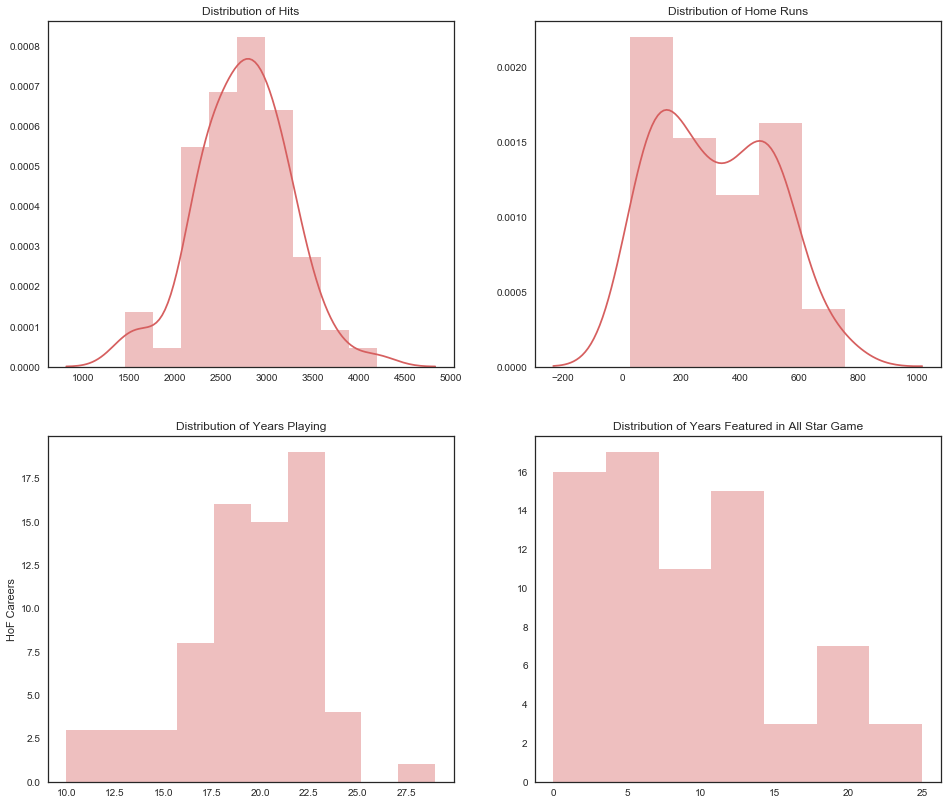

In [1514]:
# Filter players who are in HoF
df_hof = df[df['HoF'] == 1]

print(len(df_hof))

sns.set(style="white", palette="muted", color_codes=True)

# Initialize the figure and add subplots
fig = plt.figure(figsize=(16, 14))
ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(2,2,3)
ax4 = fig.add_subplot(2,2,4)

# Create distribution plots for Hits, Home Runs, Years Played and All Star Games
sns.distplot(df_hof['H'], ax = ax1, kde = True, axlabel = False, color = 'r')
ax1.set_title('Distribution of Hits')
sns.distplot(df_hof['HR'], ax = ax2, kde = True, axlabel = False, color = 'r')
ax2.set_title('Distribution of Home Runs')
sns.distplot(df_hof['years_playing'], ax = ax3, kde = False, axlabel = False, color = 'r')
ax3.set_title('Distribution of Years Playing')
ax3.set_ylabel('HoF Careers')
sns.distplot(df_hof['years_allstar'], ax = ax4, kde = False, axlabel = False, color = 'r')
ax4.set_title('Distribution of Years Featured in All Star Game')

We have 70 Hall of Famers in our data and they all boast admirable statistics. A few points to note:
* High number of Hits seem to be favorable: Most HoF players scored on average 3000 hits.
* Home Run is not so important: The majority of inductees didn't hit more than 200 home runs in their career.
* With experience comes votes: Players who have competed in more than 20 seasons make up a large portion of Hall of Famers.
* All Star Game appearances don't have much weight: In fact most players inducted only have participated in less than 10 games.

Now let's see how they fare against non-HoF players. To ensure we are comparing apples to apples, let's exclude non-HoF players with less than 10 years of experience.

1665


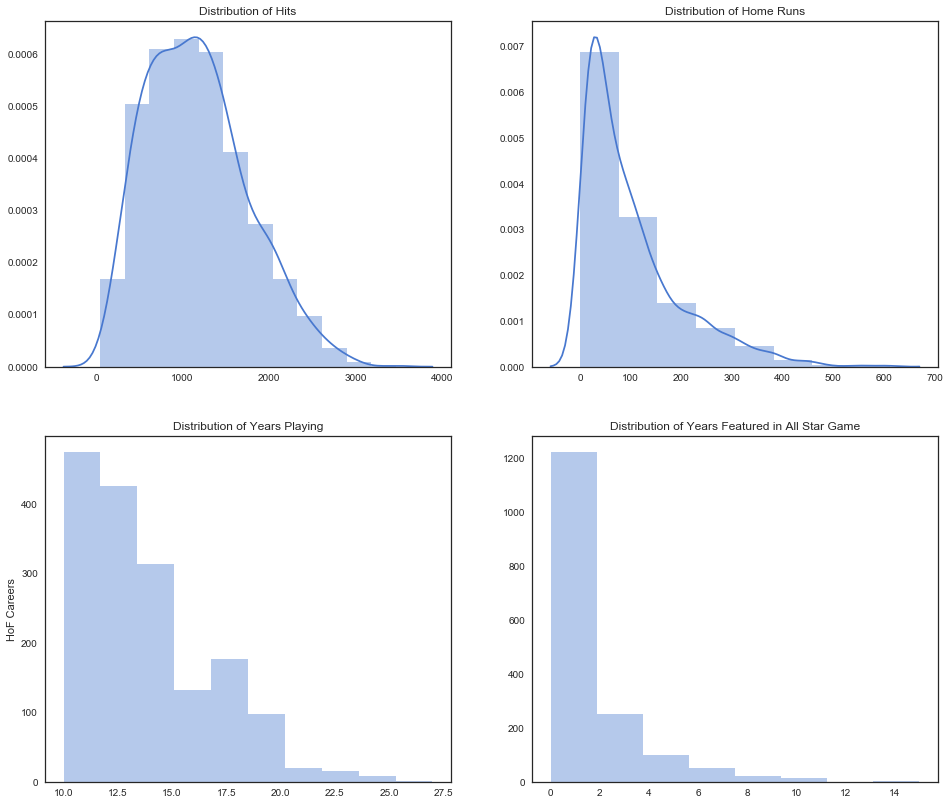

In [1515]:
# Filter `df` for players with 10 or more years of experience
df_10 = df[(df['years_playing'] >= 10) & (df['HoF'] == 0)]

print(len(df_10))

# Initialize the figure and add subplots
fig = plt.figure(figsize=(16, 14))
ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(2,2,3)
ax4 = fig.add_subplot(2,2,4)

# Create distribution plots for Hits, Home Runs, Years Played and All Star Games
sns.distplot(df_10['H'], ax = ax1, kde = True, axlabel = False, bins = 12)
ax1.set_title('Distribution of Hits')
sns.distplot(df_10['HR'], ax = ax2, kde = True, axlabel = False, bins = 8)
ax2.set_title('Distribution of Home Runs')
sns.distplot(df_10['years_playing'], ax = ax3, kde = False, axlabel = False, bins = 10)
ax3.set_title('Distribution of Years Playing')
ax3.set_ylabel('HoF Careers')
sns.distplot(df_10['years_allstar'], ax = ax4, kde = False, axlabel = False, bins = 8)
ax4.set_title('Distribution of Years Featured in All Star Game')

There are 1675 non-HoF players in our data and it's fair to say that most of them are less experienced players, which partly explains their lackluster statistics compared to the veterans who have made it to Cooperstown.

Next we want to see how Hits vs. Batting Average and Home Runs vs. Batting Average differ between HoF and non-HoF players.

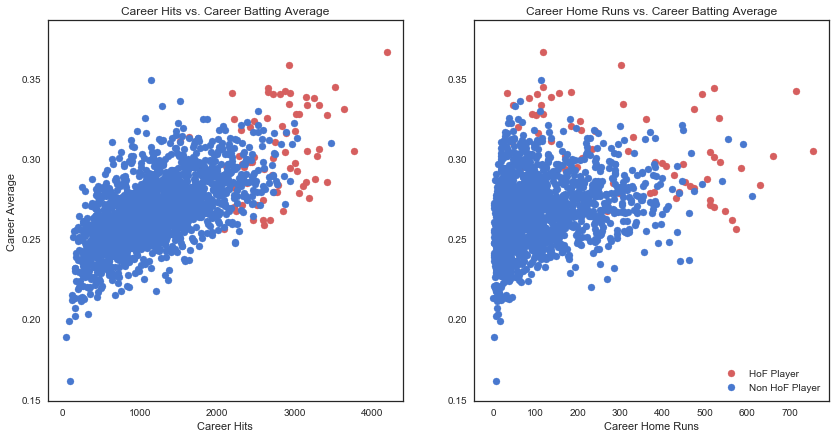

In [1516]:
# Initialize the figure and add subplots
fig = plt.figure(figsize=(14, 7))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

# Create Scatter plots for Hits vs. Average and Home Runs vs. Average
ax1.scatter(df_hof['H'], df_hof['AVE'], c='r', label='HoF Player')
ax1.scatter(df_10['H'], df_10['AVE'], c='b', label='Non HoF Player')
ax1.set_title('Career Hits vs. Career Batting Average')
ax1.set_xlabel('Career Hits')
ax1.set_ylabel('Career Average')
ax2.scatter(df_hof['HR'], df_hof['AVE'], c='r', label='HoF Player')
ax2.scatter(df_10['HR'], df_10['AVE'], c='b', label='Non HoF Player')
ax2.set_title('Career Home Runs vs. Career Batting Average')
ax2.set_xlabel('Career Home Runs')
ax2.legend(loc='lower right', scatterpoints=1)


Suffice to say, it's not surprising to see HoF players as high-achievers compared to their non-HoF teammates. There seem to be a positive correlation between career hits and career batting average regardless of HoF status, however the relationship is not as strong when it comes to home runs versus batting average. 

With this we have answered the first question posed at the beginning of ths project. To answer the second one, we need to build some machine learning model to predict whether an eligible player will ever be elected to the HoF. 

## Preparing Training and Test Data

Since a player must wait 5 years to become eligible for the HoF ballot, and can remain on the ballot for as many as 10 years then there are still eligible players who played their final season in the last 15 years. Hence those who played their last games in 2003 will be eligible for consideration in 2018 and so on. 

In [1517]:
# Filter `df` for players who retired more than 15 years ago
df_hitters = df[df['finalGame'] < 2002]

# Filter `df` for players who retired less than 15 years ago and for currently active players
df_eligible = df[df['finalGame'] >= 2002]

# Players who retired less than 15 years ago but more than 5 years ago and were inducted
early_inductees = df_eligible[df_eligible['HoF'] == 1]

# Remove these players from `df_eligible`
df_eligible = df_eligible[df_eligible['HoF'] != 1]

# Add these players to `df_hitters`
df_hitters = df_hitters.append(early_inductees)

`df_hitters` is what we will use to train and test our model on since it contains statistics of past Hall of Famers while `df_eligible` is the "new" data consisting of eligible players that we would like to make predictions of.

In [1518]:
print(len(df_hitters))

# Separate `df_hitters` into target (response) and features (predictors)
target = df_hitters['HoF']
features = df_hitters.drop(['playerID', 'nameFirst', 'nameLast', 'HoF'], axis=1)

5487


## Logistic Regression

The first model we'll try is a Logistic Regression model and we'll be using the Kfold cross-validation technique.

In [1519]:
from sklearn.cross_validation import cross_val_predict, KFold
from sklearn.linear_model import LogisticRegression

# Create Logistic Regression model
lr = LogisticRegression(class_weight='balanced')

# Create an instance of the KFold class
kf = KFold(features.shape[0], random_state=1)

# Create predictions using cross validation
predictions_lr = cross_val_predict(lr, features, target, cv=kf)

To determine accuracy, we need to compare our predictions to the target. The error metrics we'll be using are counts and rates of True Positive (TP), False Positive (FP), and False Negative (FN), whose definitions are given below:

* True Positive: The player was predicted to be in the HoF and they are a HoF member.
* False Positive: The player was predicted to be in the HoF but they are not a HoF member.
* False Negative: The player was predicted to be not in the HoF but they are indeed a HoF member.
* True Negative: The player was predicted not to be in the HoF and they are not a HoF member.

From here, we can compute the rates as follows:

* True Positive rate: # True Positive / (# True Positive + # False Negative)
* False Negative rate: # False Negative / (# False Negative + # True Positive)
* False Positive rate: # False Positive / (# False Positive + # True Negative)

In [1520]:
# Import NumPy as np
import numpy as np

# Convert predictions and target to NumPy arrays
np_predictions_lr = np.asarray(predictions_lr)
np_target = target.as_matrix()

In [1521]:
# Create a function to report TP, FP, and FN rates
def predAccuracy(predictions, target):
    
    # Determine True Positive count
    tp_filter = (predictions == 1) & (target == 1)
    tp = len(predictions[tp_filter])

    # Determine False Negative count
    fn_filter = (predictions == 0) & (target == 1)
    fn = len(predictions[fn_filter])

    # Determine False Positive count
    fp_filter = (predictions == 1) & (target == 0)
    fp = len(predictions[fp_filter])

    # Determine True Negative count
    tn_filter = (predictions == 0) & (target == 0)
    tn = len(predictions[tn_filter])

    # Determine True Positive rate
    tpr = tp / (tp + fn)

    # Determine False Negative rate
    fnr = fn / (fn_lr + tp)

    # Determine False Positive rate
    fpr = fp / (fp + tn)

    # Print each count
    print("True Positive Count: {0}".format(tp))
    print("False Negative Count: {0}".format(fn))
    print("False Positive Count: {0}".format(fp))

    # Print each rate
    print("True Positive Rate: {0:6.4f}".format(tpr))
    print("False Negative Rate: {0:6.4f}".format(fnr))
    print("False Positive Rate: {0:6.4f}".format(fpr))

In [1522]:
# Accuracy rates of logistic regression model
predAccuracy(np_predictions_lr, np_target)

True Positive Count: 60
False Negative Count: 12
False Positive Count: 35
True Positive Rate: 0.8333
False Negative Rate: 0.1667
False Positive Rate: 0.0065


## Random Forest

What we're trying to answer is a classic example of a classification problem, and it would be a crime not to mention random forest algorithm at some point. In the following we'll see how this algorithm stacks up against the logistic regression model.

In [1523]:
# Import RandomForestClassifier from sklearn
from sklearn.ensemble import RandomForestClassifier

# Create penalty dictionary
penalty = {
    0: 100,
    1: 1
}

# Create Random Forest model
rf = RandomForestClassifier(random_state=1,n_estimators=12, max_depth=11, min_samples_leaf=1, class_weight=penalty)

# Create predictions using cross validation
predictions_rf = cross_val_predict(rf, features, target, cv=kf)

# Convert predictions to NumPy array
np_predictions_rf = np.asarray(predictions_rf)

In [1524]:
# Accuracy rates of random forest model
predAccuracy(np_predictions_rf, np_target)

True Positive Count: 51
False Negative Count: 21
False Positive Count: 8
True Positive Rate: 0.7083
False Negative Rate: 0.3333
False Positive Rate: 0.0015


Although the random forest is less accurate, predicting only 51 of 72 Hall of Famers, its FN and FP counts are far fewer. Hence it will be the model of choice to make our predictions.

## Making predictions

We'll use the trained and tested random forest model to make predictions on the probability of getting voted into the HoF for each player in `df_eligible` and then print out 50 players who have the highest chance of doing so. This will also answer our second question.

In [1525]:
# Create a new features DataFrame
new_features = df_eligible.drop(['playerID', 'nameFirst', 'nameLast', 'HoF'], axis=1)

# Fit the Random Forest model
rf.fit(features, target)

# Estimate probabilities of Hall of Fame induction
probabilities = rf.predict_proba(new_features)

# Convert predictions to a DataFrame
hof_predictions = pd.DataFrame(probabilities[:,1])

# Sort the DataFrame (descending)
hof_predictions = hof_predictions.sort_values(0, ascending=False)
hof_predictions.rename(columns = {0:'prob'}, inplace = True)

# Merge the prediction with new_data
new_data.index = range(len(new_data))
new_data.head()
hof_predictions = hof_predictions.join(new_data, how = 'left')
hof_predictions.index = range(len(hof_predictions))
hof_predictions.head(50)

,prob,playerID,nameFirst,nameLast,bats_R,throws_R,finalGame,AB,R,H,...,G_ss_percent,G_lf_percent,G_cf_percent,G_rf_percent,G_of_percent,G_dh_percent,AVE,OBP,Slug_Percent,OPS
0,1.000000,ortizda01,David,Ortiz,0,0,2016,8640.0,1419.0,2472.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.842608,0.286111,0.379447,0.551505,0.930952
1,1.000000,ramirma02,Manny,Ramirez,1,1,2011,8244.0,1544.0,2574.0,...,0.000000,0.450478,0.000000,0.392702,0.841877,0.144222,0.312227,0.410477,0.585395,0.995872
2,1.000000,cabremi01,Miguel,Cabrera,1,1,2016,7853.0,1321.0,2519.0,...,0.000000,0.118321,0.000000,0.047710,0.165553,0.037214,0.320769,0.398511,0.562078,0.960589
3,1.000000,pujolal01,Albert,Pujols,1,1,2016,9138.0,1670.0,2825.0,...,0.000412,0.110882,0.000000,0.016488,0.127370,0.139736,0.309149,0.392248,0.572554,0.964802
4,1.000000,jeterde01,Derek,Jeter,1,1,2014,11195.0,1923.0,3465.0,...,0.973426,0.000000,0.000000,0.000000,0.000000,0.026574,0.309513,0.374306,0.439571,0.813877
5,1.000000,jonesch06,Chipper,Jones,0,1,2012,8984.0,1619.0,2726.0,...,0.019608,0.142457,0.000000,0.003601,0.145658,0.011204,0.303428,0.400980,0.529274,0.930254
6,1.000000,vizquom01,Omar,Vizquel,0,1,2012,10586.0,1445.0,2877.0,...,0.912736,0.000337,0.000000,0.000337,0.000674,0.002358,0.271774,0.329143,0.352069,0.681212
7,1.000000,heltoto01,Todd,Helton,0,0,2013,7962.0,1401.0,2519.0,...,0.000000,0.005785,0.000000,0.000890,0.006676,0.000890,0.316378,0.413862,0.539061,0.952923
8,1.000000,abreubo01,Bobby,Abreu,0,1,2014,8480.0,1453.0,2470.0,...,0.000000,0.058557,0.008660,0.820619,0.881649,0.066392,0.291274,0.394703,0.474764,0.869467
9,1.000000,beltrad01,Adrian,Beltre,1,1,2016,10295.0,1428.0,2942.0,...,0.002574,0.000000,0.000000,0.000000,0.000000,0.030882,0.285770,0.337833,0.479845,0.817678


## Limitations

While it's nice to be able to tell who are likely to get elected in future ballots, this is a naïve model: we don’t predict the career trajectories of current players. We simply ask: if they retired now, and we relax the 10-year minimum requirement, would their statistical output qualify them for the Hall of Fame based on what we’ve seen voters do in the past?

This brings us to a related question: how much would steroid suspicions hurt the chance of getting in? Take Ivan Rodriguez for example. Despite allegations of injections of PED in 2003, he nevertheless made it in to the HoF in 2016. Along with cases for Tim Raines and Jeff Bagwell, who were also suspected of steroid use, this proves voters do forgive, but on what conditions and to what extent we never know. 

## References

1. [Lahman's Baseball Database](http://www.seanlahman.com/baseball-archive/statistics/)
2. [Scikit-Learn Tutorial: Baseball Analytics in Python Pt 2](https://www.datacamp.com/community/tutorials/scikit-learn-tutorial-baseball-2)
3. [Hall of Famers - Rules for Election](http://baseballhall.org/hall-of-famers/bbwaa-rules-for-election)
4. [What Are the Major Eras of Major League Baseball History?](http://www.huffingtonpost.com/quora/what-are-the-major-eras-o_b_3547814.html)
5. [List of people banned from Major League Baseball](https://en.wikipedia.org/wiki/List_of_people_banned_from_Major_League_Baseball)
6. [These 11 Players' Hall of Fame Inductions Have Been Sabotaged by Steroid Allegations and Admissions](http://www.complex.com/sports/2016/07/players-hall-of-fame-inductions-destroyed-steroid-allegations/)
7. [Top 15 Baseball Players Who Have Used Performance Enhancing Drugs](http://www.thesportster.com/baseball/top-15-baseball-players-who-have-used-performance-enhancing-drugs/)
8. [Hall of Fame Classification Using Random Forest](https://baseballwithr.wordpress.com/2014/11/26/hall-of-fame-classification-using-randomforest/)